*This notebook contains an analysis of Rep-seq data for Cohort II*


# Russian population analysis

This notebook contains an analysis of Rep-seq data for Cohort II, including histigrams and clustermaps of gene usage. Also, functional and ninfunctional analysis was done. 

In [1]:
import os
import re


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
trbv_matrix = pd.read_csv('trbv_matrix_batch.csv').drop('Unnamed: 0', axis=1)
trbv_matrix

,TRBV6-4*01,TRBV12-4*01,TRBV6-6*01,TRBV30*01,TRBV3-1*01,TRBV6-3*01,TRBV10-3*01,TRBV5-8*01,TRBV7-1*01,TRBV18*01,...,TRBV23-1*01,TRBV11-3*01,TRBV5-7*01,TRBV20-1*01,TRBV10-1*01,TRBV7-9*01,TRBV21-1*01,TRBV5-6*01,TRBV14*01,TRBV25-1*01
0,0.013509,0.000799,0.016995,0.034788,0.028324,0.0,0.017939,0.007117,0.000000,0.022950,...,0.005229,0.007117,0.000799,0.064856,0.007989,0.039582,0.017358,0.020917,0.009078,0.005810
1,0.008890,0.001014,0.020120,0.037043,0.020822,0.0,0.011698,0.004913,0.000078,0.035327,...,0.005381,0.014739,0.001248,0.091866,0.008968,0.038447,0.019496,0.019028,0.012322,0.008656
2,0.014107,0.000564,0.017944,0.014107,0.019242,0.0,0.014502,0.007731,0.000000,0.030471,...,0.007787,0.012301,0.000677,0.075951,0.007223,0.040345,0.015912,0.018057,0.011003,0.006151
3,0.024415,0.001361,0.013526,0.027818,0.028073,0.0,0.017780,0.005359,0.000000,0.026882,...,0.007826,0.007401,0.001021,0.091791,0.008507,0.043471,0.021693,0.017865,0.012590,0.011484
4,0.006885,0.001721,0.015491,0.018072,0.024957,0.0,0.020654,0.005164,0.000000,0.018933,...,0.006885,0.006024,0.000000,0.086059,0.017212,0.055077,0.017212,0.021515,0.015491,0.010327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.007690,0.001709,0.018513,0.015095,0.018798,0.0,0.013671,0.006836,0.000000,0.034748,...,0.004842,0.013386,0.001424,0.076047,0.009684,0.039875,0.023355,0.013671,0.019937,0.005412
233,0.015102,0.000604,0.014860,0.017398,0.037695,0.0,0.018606,0.007007,0.000000,0.026338,...,0.007249,0.005920,0.001329,0.078531,0.011961,0.039265,0.018123,0.018243,0.012202,0.006403
234,0.024217,0.002088,0.013779,0.019624,0.016284,0.0,0.016701,0.009186,0.000000,0.021294,...,0.007098,0.008351,0.000000,0.096868,0.006263,0.032568,0.012526,0.016284,0.012109,0.007516
235,0.015696,0.000000,0.017809,0.034712,0.009055,0.0,0.022638,0.006942,0.000000,0.011772,...,0.006037,0.005735,0.002113,0.101419,0.009055,0.032599,0.012375,0.031391,0.010866,0.003018


In [3]:
trbj_matrix = pd.read_csv('trbj_matrix_batch.csv').drop('Unnamed: 0', axis=1)
trbj_matrix

,TRBJ2-7*01,TRBJ2-1*01,TRBJ1-1*01,TRBJ2-5*01,TRBJ1-6*01,TRBJ2-3*01,TRBJ2-2P*01,TRBJ1-3*01,TRBJ2-6*01,TRBJ1-2*01,TRBJ1-4*01,TRBJ1-5*01,TRBJ2-4*01,TRBJ2-2*01
0,0.185199,0.054688,0.209456,0.025855,0.059264,0.037475,0.0,0.048006,0.022224,0.163556,0.058973,0.097102,0.003704,0.034498
1,0.227794,0.073852,0.164314,0.020120,0.063714,0.027061,0.0,0.052874,0.022772,0.155736,0.060048,0.100678,0.004211,0.026827
2,0.153369,0.101794,0.139939,0.069800,0.053211,0.086221,0.0,0.037806,0.020370,0.135368,0.048076,0.086616,0.011680,0.055750
3,0.185028,0.165972,0.129562,0.051723,0.050532,0.067120,0.0,0.037006,0.020162,0.098426,0.047044,0.076138,0.009188,0.062101
4,0.160069,0.084337,0.156627,0.038726,0.071429,0.052496,0.0,0.044750,0.012909,0.175559,0.063683,0.098967,0.003442,0.037005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.100826,0.146682,0.108801,0.095699,0.041299,0.131017,0.0,0.033609,0.023070,0.108516,0.039020,0.074623,0.023070,0.073768
233,0.238130,0.072732,0.153437,0.027425,0.062100,0.037936,0.0,0.043011,0.026821,0.126978,0.059804,0.110306,0.004108,0.037212
234,0.205846,0.137370,0.108977,0.053862,0.051357,0.086848,0.0,0.032985,0.022965,0.100626,0.051357,0.093946,0.007098,0.046764
235,0.117718,0.046785,0.223363,0.011772,0.085119,0.017809,0.0,0.045578,0.034410,0.170238,0.079686,0.134923,0.001509,0.031090


# V genes

Histograms of the use of each of the genes

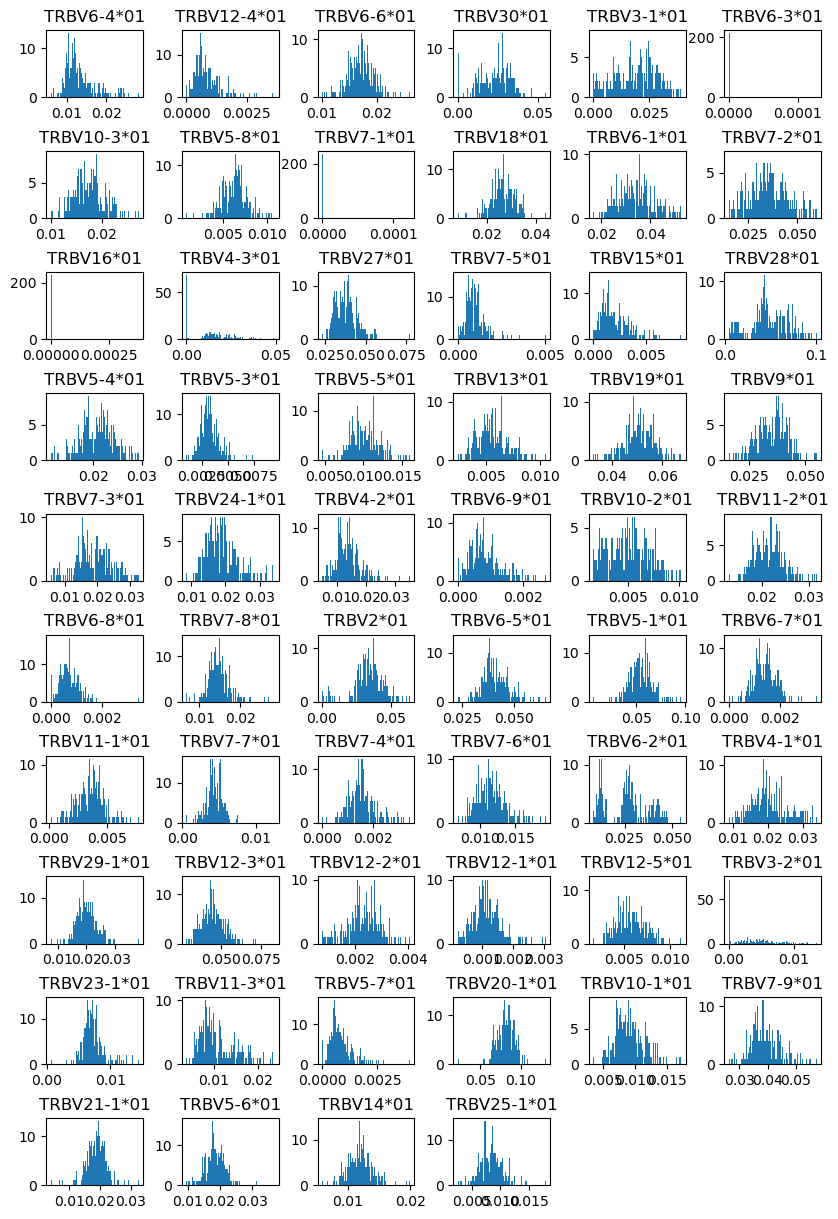

In [4]:
plt.figure(figsize=(10,15))

for i, column in enumerate(trbv_matrix.columns):
    plt.subplot(10, 6, i+1)
    plt.hist(x=trbv_matrix[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()

Let's take a closer look at the genes TRBV7-1, TRBV16, TRBV4-3, TRBV6-3, TRBV3-2.

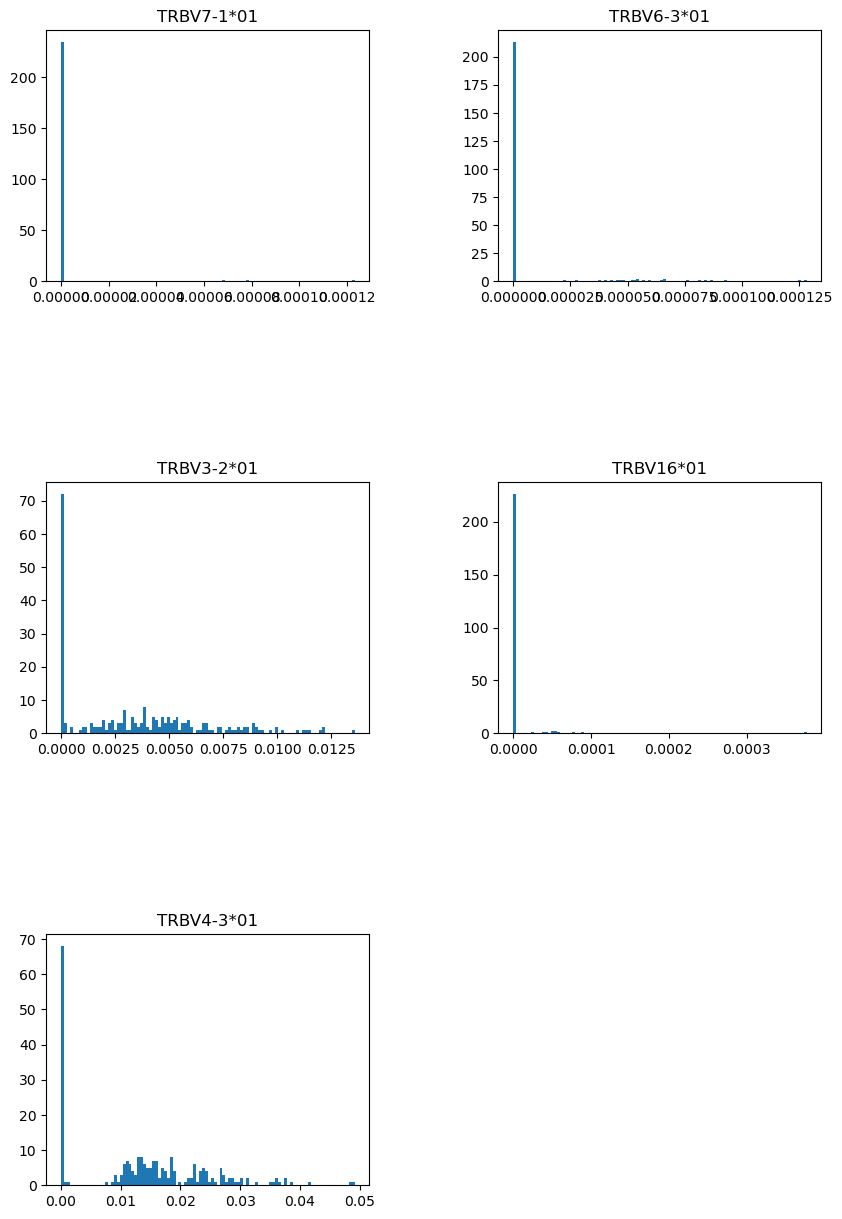

In [5]:
columns_to_use = ['TRBV7-1*01', 'TRBV6-3*01', 'TRBV3-2*01', 'TRBV16*01', 'TRBV4-3*01']

plt.figure(figsize=(10,15))

for i, column in enumerate(trbv_matrix[columns_to_use]):
    plt.subplot(3, 2, i+1)
    plt.hist(x=trbv_matrix[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()

In [6]:
print(trbv_matrix['TRBV7-1*01'].value_counts(), 
      trbv_matrix['TRBV6-3*01'].value_counts(),
      trbv_matrix['TRBV16*01'].value_counts())

TRBV7-1*01
0.000000    234
0.000078      1
0.000123      1
0.000069      1
Name: count, dtype: int64 TRBV6-3*01
0.000000    213
0.000128      1
0.000046      1
0.000027      1
0.000049      1
0.000052      1
0.000041      1
0.000065      1
0.000092      1
0.000081      1
0.000054      1
0.000023      1
0.000055      1
0.000038      1
0.000066      1
0.000054      1
0.000087      1
0.000043      1
0.000059      1
0.000065      1
0.000125      1
0.000077      1
0.000057      1
0.000084      1
0.000046      1
Name: count, dtype: int64 TRBV16*01
0.000000    226
0.000052      1
0.000054      1
0.000039      1
0.000050      1
0.000024      1
0.000377      1
0.000056      1
0.000087      1
0.000057      1
0.000078      1
0.000044      1
Name: count, dtype: int64


These genes can definitely be removed, but with TRBV3-2, TRBV4-3, we need to think about it. But for now, we'll delete them too.

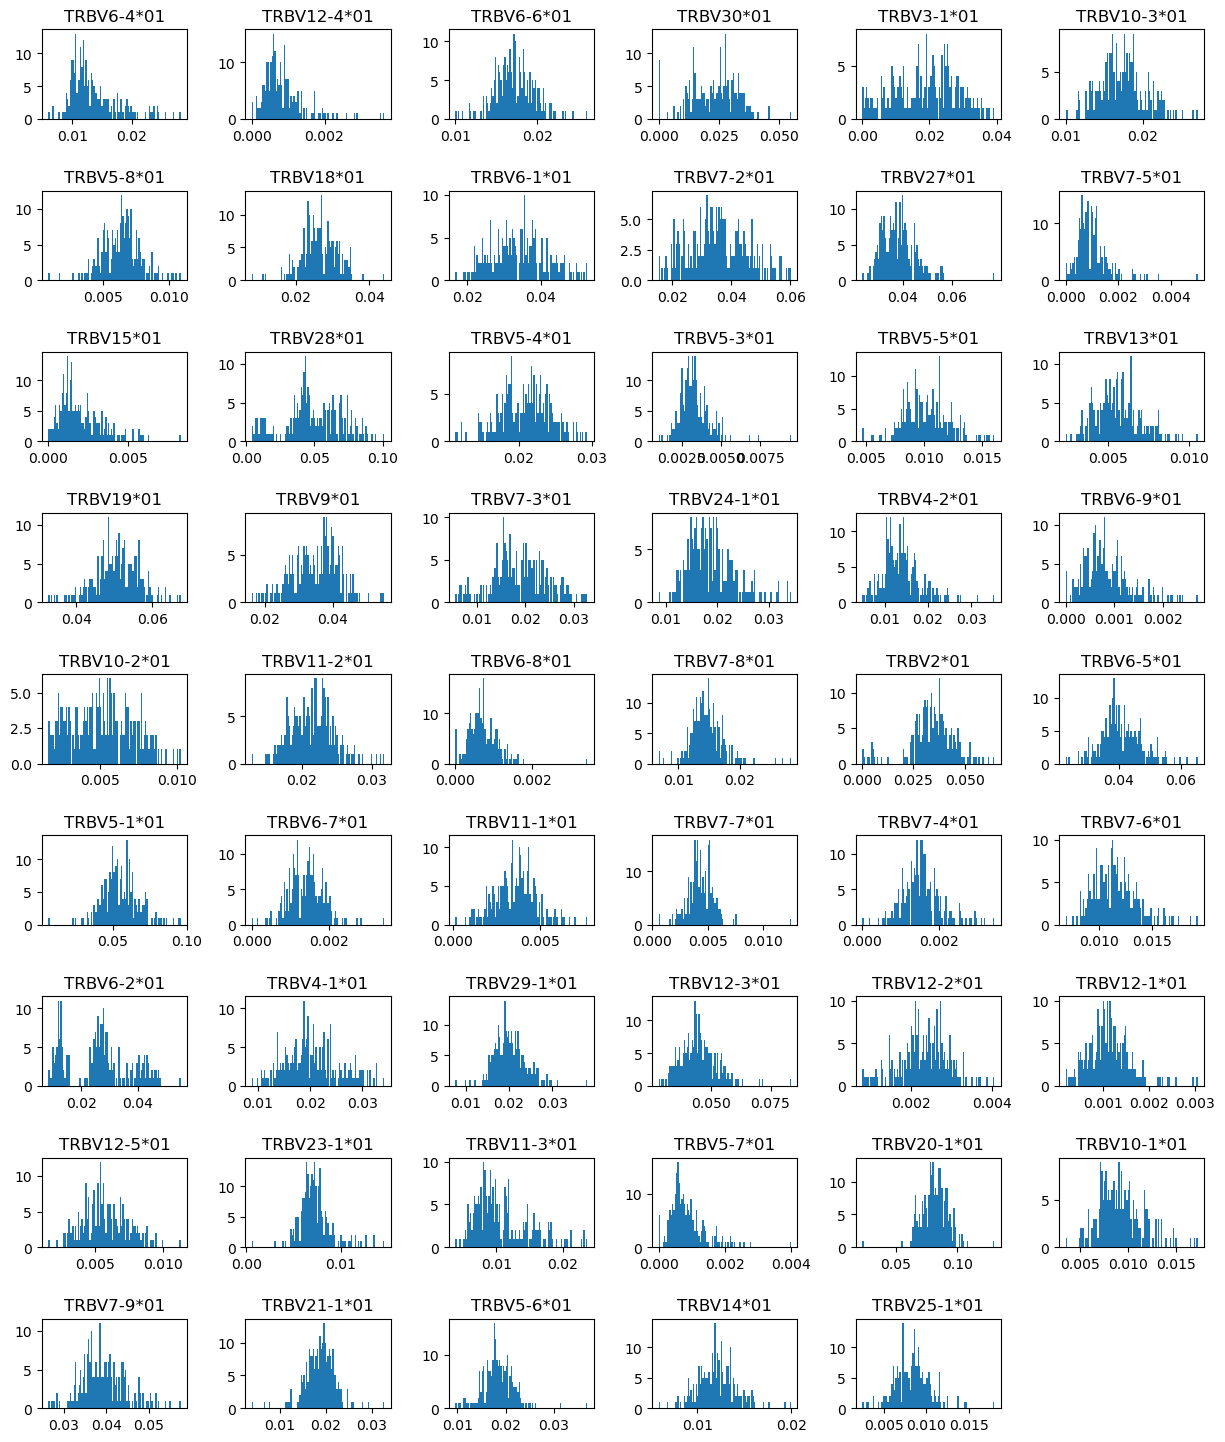

In [7]:
trbv_matrix_filtered = trbv_matrix.copy()
trbv_matrix_filtered = trbv_matrix_filtered.drop(['TRBV7-1*01', 'TRBV6-3*01', 'TRBV3-2*01', 'TRBV16*01', 'TRBV4-3*01'], axis=1)

plt.figure(figsize=(15,20))

for i, column in enumerate(trbv_matrix_filtered.columns):
    plt.subplot(10, 6, i+1)
    plt.hist(x=trbv_matrix_filtered[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()

# J genes

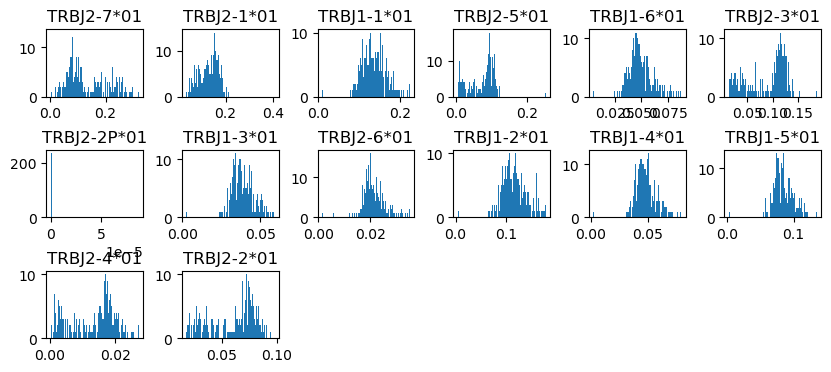

In [8]:
plt.figure(figsize=(10,15))

for i, column in enumerate(trbj_matrix.columns):
    plt.subplot(10, 6, i+1)
    plt.hist(x=trbj_matrix[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()

The TRBJ2-2P gene is a pseudo-gene, it can be deleted.

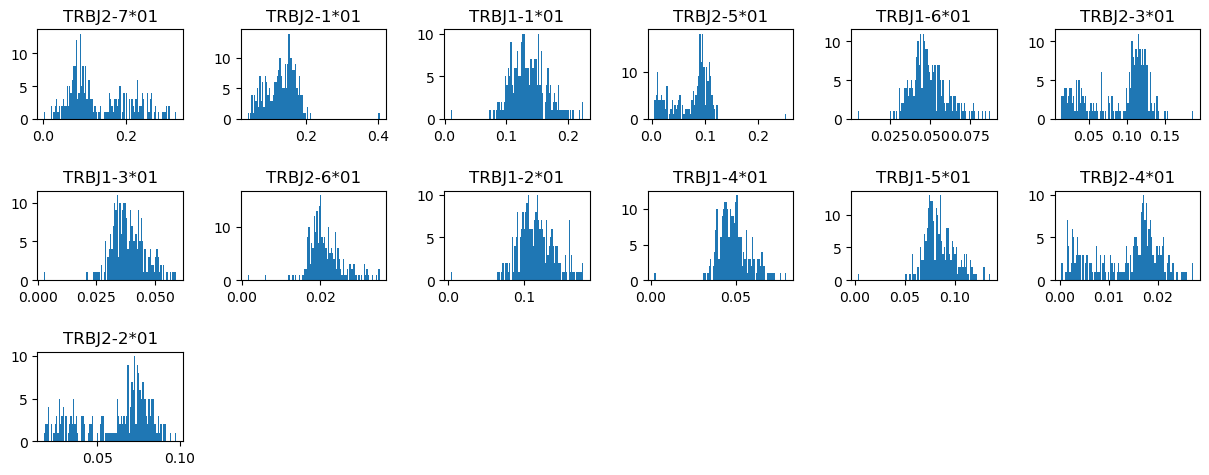

In [9]:
trbj_matrix_filtered = trbj_matrix.copy()
trbj_matrix_filtered = trbj_matrix_filtered.drop(['TRBJ2-2P*01'], axis=1)

plt.figure(figsize=(15,20))

for i, column in enumerate(trbj_matrix_filtered.columns):
    plt.subplot(10, 6, i+1)
    plt.hist(x=trbj_matrix_filtered[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()

In [15]:
trbj_matrix_filtered.to_csv('trbj_clean_batch.csv')

# Cluster maps

Here are the clustermaps for V and J genes based on the correlation matrix.

## V genes

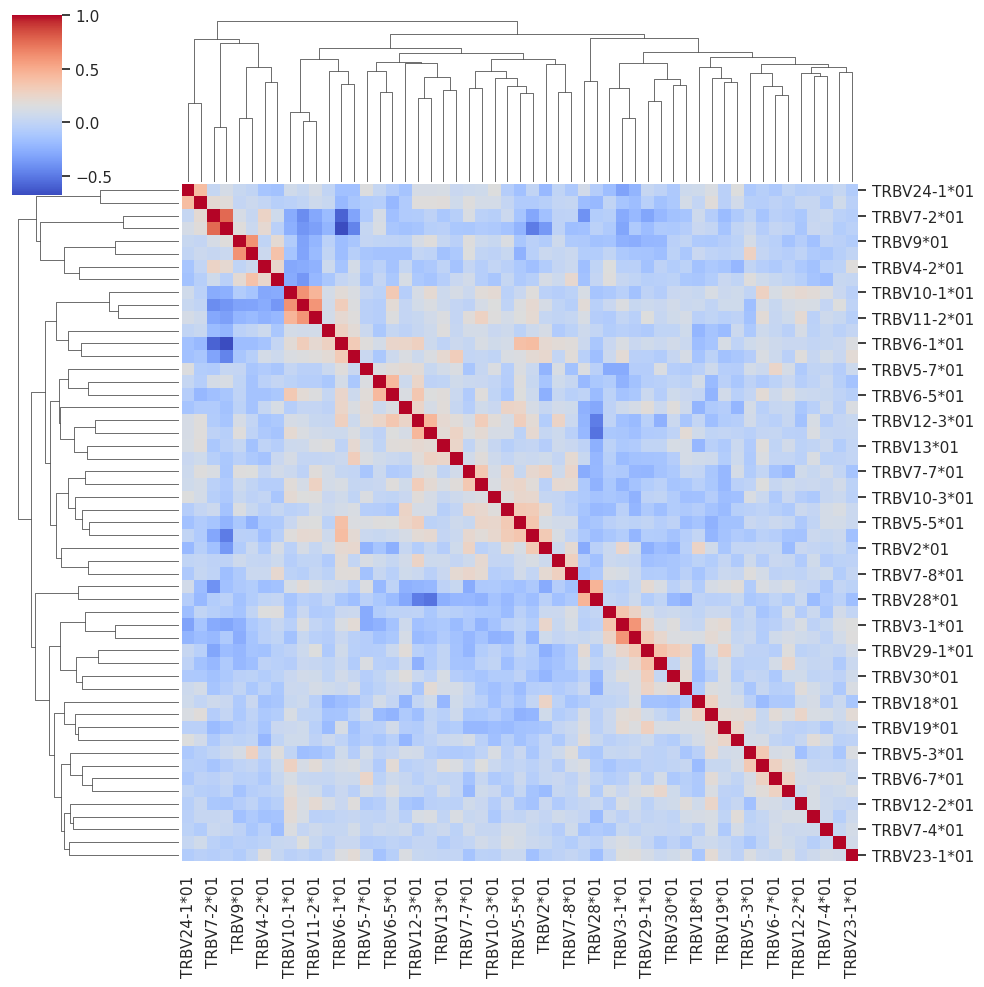

In [10]:
sns.set_theme(rc={'figure.figsize':(8.7,8.27)})

corr_v_matrix_filtered = trbv_matrix_filtered.corr() 
sns.clustermap(corr_v_matrix_filtered, cmap= 'coolwarm');

## J genes

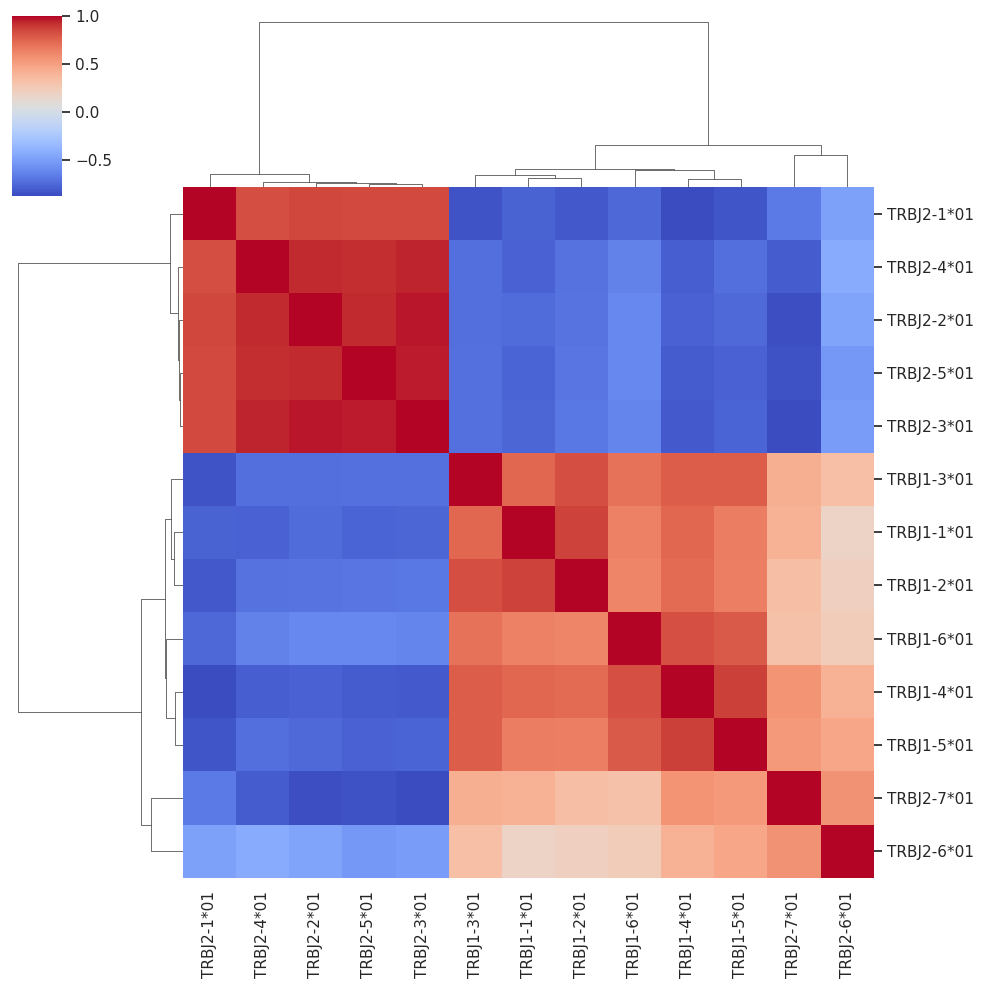

In [11]:
corr_j_matrix_filtered = trbj_matrix_filtered.corr() 
sns.clustermap(corr_j_matrix_filtered, cmap= 'coolwarm');

## V vs J genes

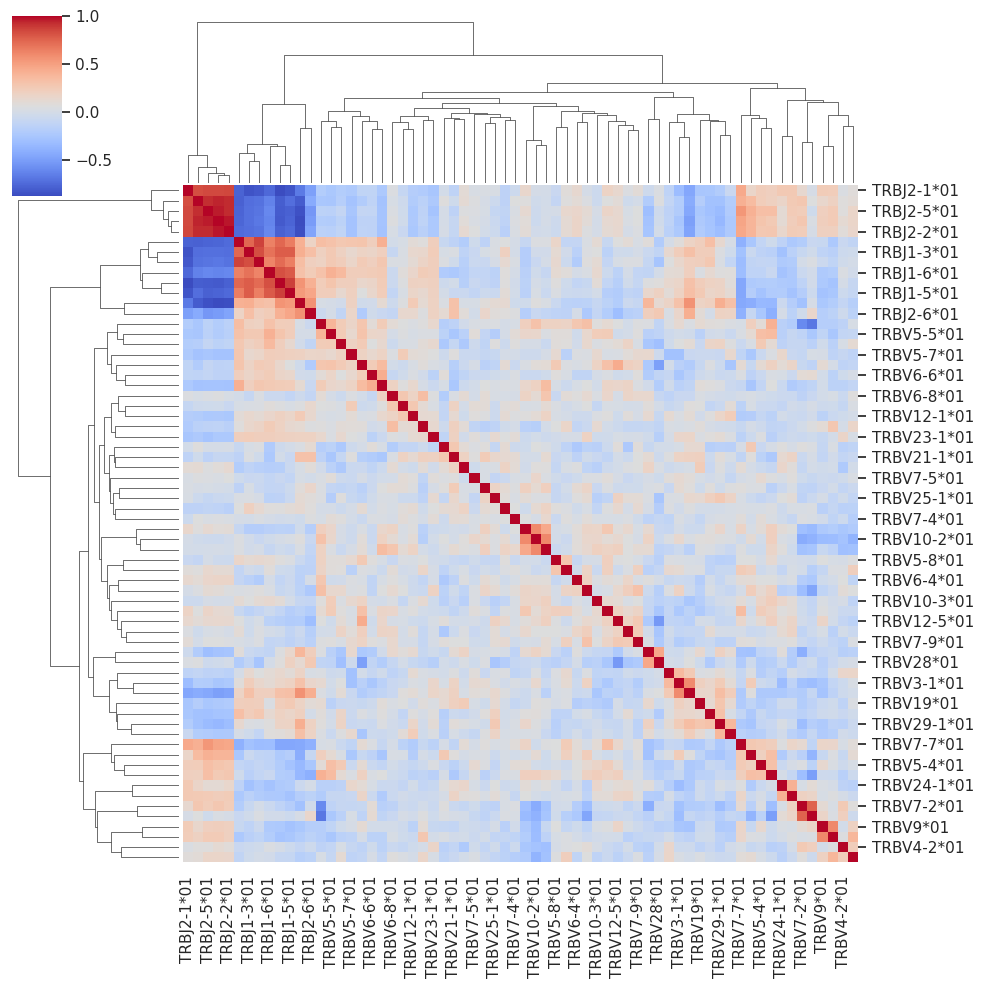

In [12]:
v_j_merged_filtered = pd.concat([trbj_matrix_filtered, trbv_matrix_filtered], axis=1)

corr_v_j_matrix_filtered = v_j_merged_filtered.corr()
sns.clustermap(corr_v_j_matrix_filtered, cmap= 'coolwarm');

# Heatmap for each patient

## J genes

At first, without normalization to the maximum:

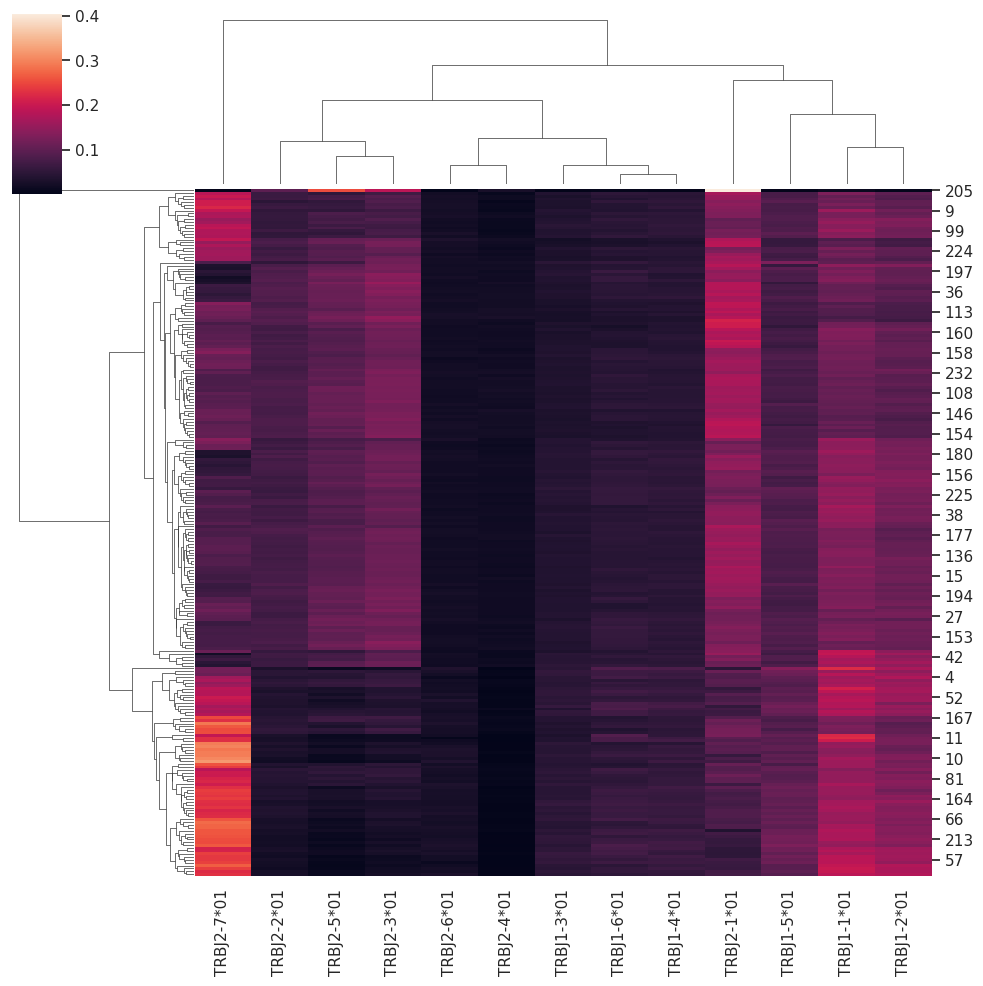

In [13]:
sns.clustermap(trbj_matrix_filtered);

In [14]:
trbj_matrix_filtered_max = trbj_matrix_filtered.copy()
trbj_matrix_filtered_max = trbj_matrix_filtered_max.apply(lambda column: column / column.max(), axis=0)
trbj_matrix_filtered_max

,TRBJ2-7*01,TRBJ2-1*01,TRBJ1-1*01,TRBJ2-5*01,TRBJ1-6*01,TRBJ2-3*01,TRBJ1-3*01,TRBJ2-6*01,TRBJ1-2*01,TRBJ1-4*01,TRBJ1-5*01,TRBJ2-4*01,TRBJ2-2*01
0,0.578450,0.135370,0.932536,0.102003,0.675682,0.199775,0.811072,0.631411,0.921611,0.740067,0.719686,0.136362,0.352289
1,0.711492,0.182806,0.731556,0.079377,0.726419,0.144256,0.893306,0.646974,0.877547,0.753561,0.746192,0.155035,0.273953
2,0.479032,0.251973,0.623034,0.275373,0.606671,0.459627,0.638737,0.578746,0.762780,0.603315,0.641962,0.430015,0.569314
3,0.577916,0.410832,0.576833,0.204054,0.576127,0.357807,0.625211,0.572821,0.554616,0.590364,0.564306,0.338242,0.634174
4,0.499960,0.208761,0.697329,0.152781,0.814379,0.279845,0.756062,0.366757,0.989249,0.799177,0.733509,0.126730,0.377894
...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.314920,0.363083,0.484401,0.377548,0.470860,0.698428,0.567821,0.655462,0.611471,0.489674,0.553075,0.849337,0.753316
233,0.743775,0.180034,0.683130,0.108197,0.708019,0.202233,0.726670,0.762032,0.715503,0.750498,0.817545,0.151228,0.380002
234,0.642939,0.340032,0.485185,0.212495,0.585537,0.462970,0.557291,0.652455,0.567013,0.644491,0.696291,0.261318,0.477552
235,0.367681,0.115808,0.994450,0.046442,0.970470,0.094935,0.770044,0.977635,0.959267,1.000000,1.000000,0.055562,0.317485


With normalization to the maximum.

Here you need to look at the vertical columns. There are genes that are used by one cohort of people and not by another.

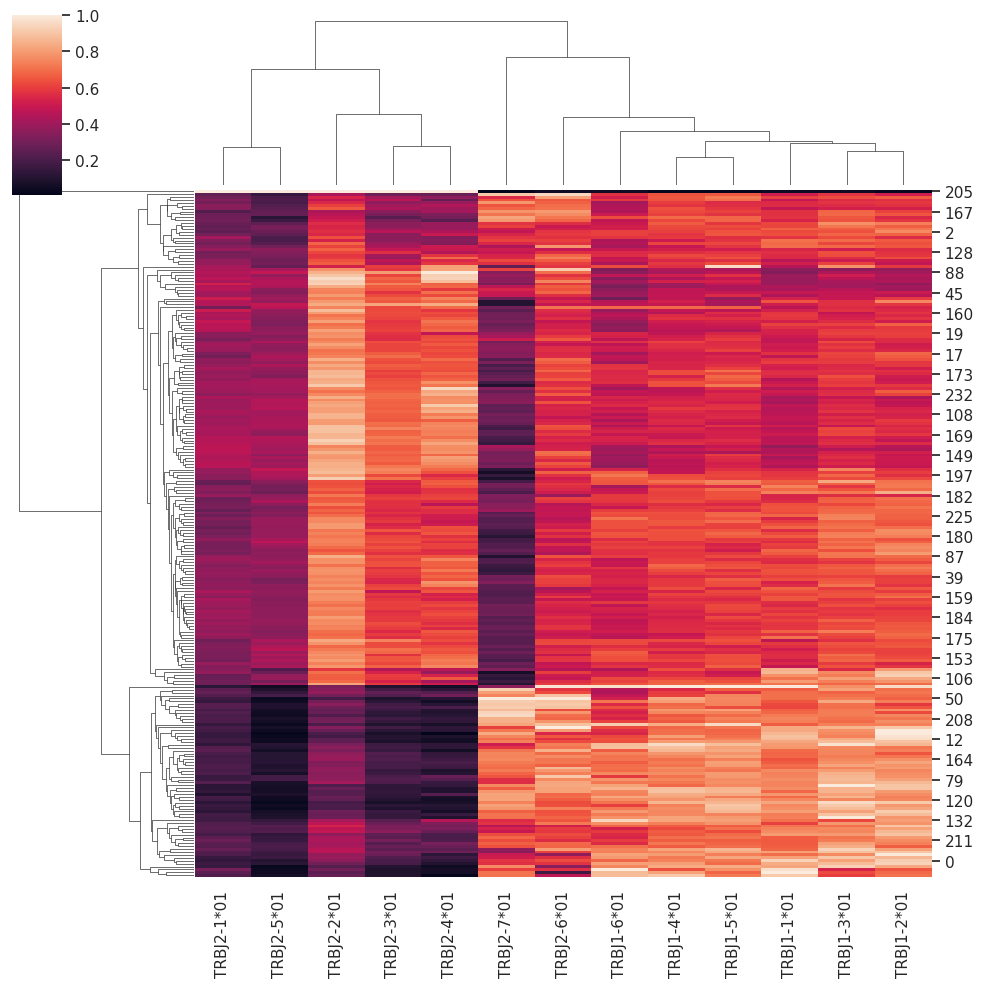

In [15]:
sns.clustermap(trbj_matrix_filtered_max);

## V genes

In [16]:
trbv_matrix_filtered_max = trbv_matrix_filtered.copy()

trbv_matrix_filtered_max = trbv_matrix_filtered_max.apply(lambda column: column / column.max(), axis=0)
trbv_matrix_filtered_max

,TRBV6-4*01,TRBV12-4*01,TRBV6-6*01,TRBV30*01,TRBV3-1*01,TRBV10-3*01,TRBV5-8*01,TRBV18*01,TRBV6-1*01,TRBV7-2*01,...,TRBV23-1*01,TRBV11-3*01,TRBV5-7*01,TRBV20-1*01,TRBV10-1*01,TRBV7-9*01,TRBV21-1*01,TRBV5-6*01,TRBV14*01,TRBV25-1*01
0,0.480713,0.219597,0.651729,0.633886,0.721100,0.660379,0.655179,0.521155,0.656175,0.611183,...,0.360097,0.299534,0.199610,0.498655,0.464159,0.689356,0.532710,0.566673,0.455345,0.323327
1,0.316366,0.278669,0.771585,0.674966,0.530097,0.430626,0.452259,0.802215,0.500314,0.734091,...,0.370552,0.620289,0.311761,0.706329,0.521056,0.669587,0.598337,0.515517,0.618017,0.481713
2,0.501999,0.155104,0.688126,0.257043,0.489864,0.533850,0.711613,0.691932,0.458402,0.769528,...,0.536236,0.517686,0.169184,0.583961,0.419637,0.702656,0.488351,0.489193,0.551893,0.342270
3,0.868829,0.374139,0.518714,0.506878,0.714702,0.654520,0.493349,0.610445,0.828343,0.372097,...,0.538958,0.311472,0.255065,0.705749,0.494258,0.757091,0.665753,0.483993,0.631498,0.639095
4,0.244996,0.473107,0.594046,0.329299,0.635368,0.760333,0.475315,0.429931,0.931074,0.400751,...,0.474104,0.253521,0.000000,0.661675,1.000000,0.959232,0.528225,0.582877,0.776961,0.574685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.273658,0.469738,0.709964,0.275057,0.478571,0.503280,0.629240,0.789063,0.432488,0.895270,...,0.333433,0.563364,0.355820,0.584698,0.562632,0.694459,0.716768,0.370385,1.000000,0.301146
233,0.537418,0.166047,0.569883,0.317006,0.959655,0.684931,0.645047,0.598089,0.763636,0.403874,...,0.499193,0.249141,0.332056,0.603798,0.694926,0.683849,0.556178,0.494250,0.612042,0.356334
234,0.861783,0.573852,0.528399,0.357578,0.414565,0.614828,0.845577,0.483556,0.499287,0.722189,...,0.488802,0.351436,0.000000,0.744790,0.363883,0.567203,0.384425,0.441166,0.607331,0.418236
235,0.558544,0.000000,0.682943,0.632491,0.230533,0.833372,0.639061,0.267316,0.733337,0.657617,...,0.415718,0.241354,0.527920,0.779774,0.526109,0.567743,0.379803,0.850461,0.545022,0.167971


/home/svinogradova/.conda/envs/haplotypes/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/svinogradova/.conda/envs/haplotypes/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


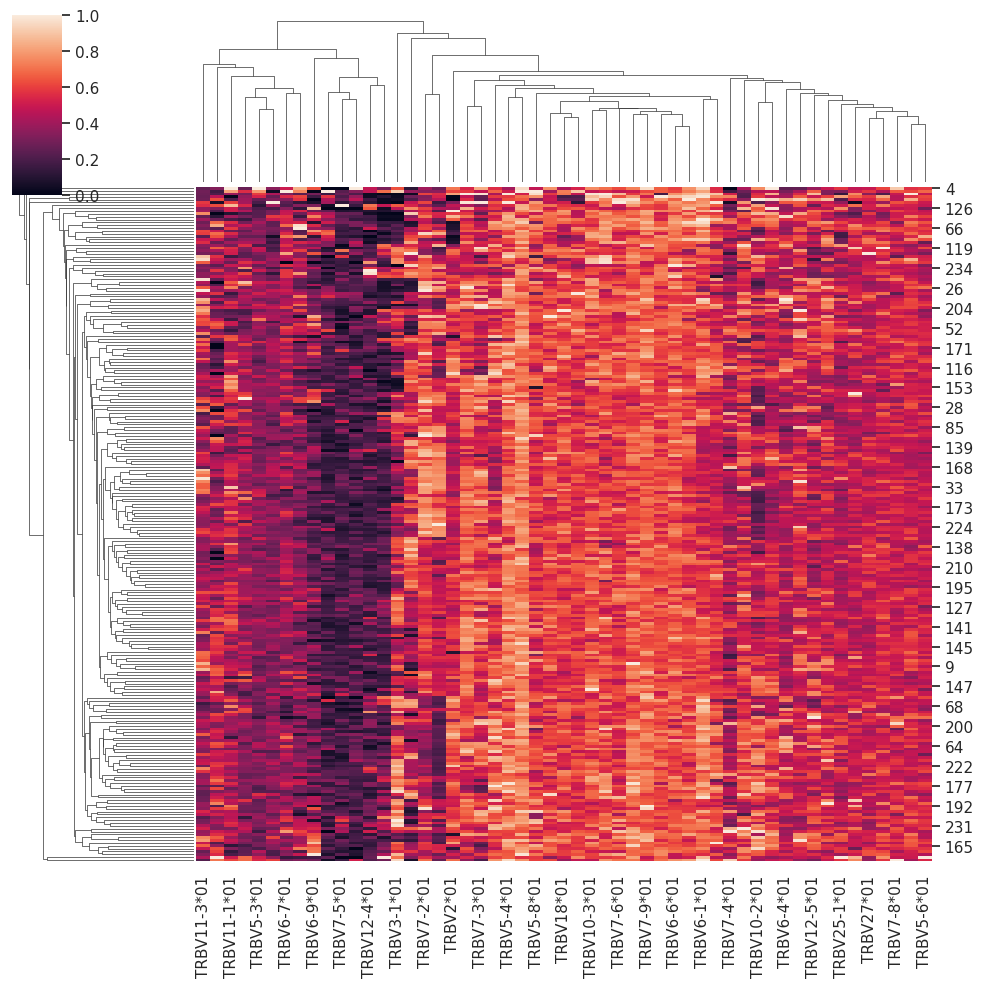

In [17]:
sns.clustermap(trbv_matrix_filtered_max);

#  Nonfunctional vs Onlyfunctional sequences analysis

Here are the functions written for the analysis:

In [3]:
def plot_hist_usage(gene_names: list, usage_matrix, n_cols: int = 5, file_name: str = None):
    """Visualise gene usage histograms
    arguments:
        - gene_names: list of gene names for visualisation
        - usage_matrix: matrix with gene usage value
        - n_cols: number of columns for pictures
        - file_name: file name for saving pictures
    """
    
    plt.figure(figsize=(10,15))
    
    n_genes = len(gene_names)
    if n_genes % n_cols != 0:
        n_rows = n_genes // n_cols + 1 
    else: 
        n_rows = n_genes // n_cols 
    
    for i, column in enumerate(gene_names):
        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(x=usage_matrix[column], bins=100)
        plt.title(f'{column}') 
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();

In [4]:
def plot_hist_of_vs_nf(gene_names: list, of_usage_matrix, nf_usage_matrix, n_cols: int = 5, file_name: str = None):
    """Visualise joint distributions of only functional and nonfunctional sequences gene usage histograms
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - n_cols: number of columns for pictures
        - file_name: file name for saving pictures
    """
    
    plt.figure(figsize=(20,30))
    
    n_genes = len(gene_names)
    if n_genes % n_cols != 0:
        n_rows = n_genes // n_cols + 1 
    else: 
        n_rows = n_genes // n_cols 

    for i, column in enumerate(gene_names):
        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(x=of_usage_matrix[column], bins=50, alpha=0.9, label='of')#blue
        plt.hist(x=nf_usage_matrix[column], bins=50, alpha=0.3, label='nf')#yellow
        plt.title(f'{column}')
        plt.legend(fontsize="9")
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();

In [5]:
def plot_scatter_of_vs_nf(gene_names: list, of_usage_matrix, nf_usage_matrix, file_name = None, clonotype_counts = None):
    """Visualise and calculate regression coefficients of scatterplots for only functional and nonfunctional sequences gene usage
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - file_name: file name for saving pictures
        - clonotype_counts: file name for saving clonotype counts dict
    return:
        - regression coefficients 
    """
    
    tr_fit_koef = pd.DataFrame(columns=['gene', 'koef'])

    plt.figure(figsize=(20,30))

    for i, column in enumerate(gene_names):
        x = of_usage_matrix[column]
        y = nf_usage_matrix[column]
        plt.subplot(len(gene_names) // 5 + 1, 5, i+1)

        plt.scatter(x=x, y=y, s=1)
        lim = max(plt.ylim()[1], plt.xlim()[1])
        xy_lim = (0, lim)
        plt.plot(xy_lim, xy_lim, color = 'r', label='y=x')

        x = np.array(x)
        y = np.array(y)
        x = np.append(x, [0])
        y = np.append(y, [0])
        x = np.array(x)[:,np.newaxis]
        a, _, _, _ = np.linalg.lstsq(x, y)
        plt.plot(x, a*x, 'blue', label='regression')
        tr_fit_koef.loc[i] = [column, a[0]] 

        plt.text(xy_lim[1]-0.8*xy_lim[1], 0, f'k={float(a):.2f}', fontsize=10)
        if clonotype_counts is not None:
            clonotype_count_dict = np.load(clonotype_counts,allow_pickle='TRUE').item()
            plt.text(xy_lim[1]-0.8*xy_lim[1], 0.15*xy_lim[1], f'%={float(clonotype_count_dict[column]):.2f}', fontsize=10)
        
        plt.title(f'{column}') 
        plt.xlabel("of usage")
        plt.ylabel("nf usage")
        plt.legend(fontsize="8")
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();
    
    return tr_fit_koef

In [7]:
def calculate_p_value_ks_test(gene_names: list, of_usage_matrix, nf_usage_matrix, adj_bonf: bool = False)->dict:
    """Kolmogorov-Smirnov test calculation for gene-usage of nonfunctional and only functional sequences
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - adj_bonf: if bonferrony adjastment for p-value is necessary
    return:
        - dictionary with p-value for each gene
    """
    
    p_value_dict = {}
    
    for gene in gene_names:
        p_value_dict[gene] = stats.ks_2samp(nf_usage_matrix[gene], of_usage_matrix[gene]).pvalue
        
    if adj_bonf:
        adj = len(p_value_dict)
        for k, v in p_value_dict.items():
            p_value_dict[k] = v * adj
            if p_value_dict[k] > 1:
                p_value_dict[k] = 1
        
    return p_value_dict

## Beta chain

In [31]:
#nonfunc TRB-V
nf_trbv_matrix = pd.read_csv('../data/cohort_II/nonfunctional_corrected/nf_trbv_hip_norm.csv').drop(['Unnamed: 0'], axis=1)
nf_trbv_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
nf_trbv_matrix.head(3)

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-9,...,TRBV12-2,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.028406,0.032141,0.013968,0.007204,0.009259,0.002841,0.017420,0.023761,0.012398,0.002919,...,0.008914,0.004300,0.012210,0.012210,0.002998,0.016353,0.004143,0.024639,0.008789,HIP14174.txt
1,0.034543,0.029873,0.007659,0.006164,0.007386,0.002658,0.004224,0.032330,0.014886,0.002471,...,0.007932,0.003908,0.011581,0.018004,0.003563,0.017185,0.005604,0.026870,0.010245,HIP13142.txt
2,0.034879,0.029992,0.007768,0.007579,0.009997,0.002847,0.006842,0.033233,0.015433,0.003018,...,0.008368,0.004098,0.018194,0.015793,0.003618,0.014782,0.005865,0.023493,0.008728,HIP02928.txt


In [32]:
#onlyfunc TRB-V
of_trbv_matrix = pd.read_csv('../data/cohort_II/onlyfunctional_corrected/of_trbv_hip_norm.csv').drop(['Unnamed: 0'], axis=1)
of_trbv_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
of_trbv_matrix.head(3)

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-6,TRBV6-5,...,TRBV13,TRBV12-5,TRBV12-4,TRBV11-3,TRBV11-2,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.037347,0.039373,0.029327,0.003782,0.011192,0.000920,0.009024,0.028995,0.025907,0.041859,...,0.007220,0.005844,0.049273,0.004592,0.016711,0.018058,0.005965,0.004935,0.000774,HIP14174.txt
1,0.034356,0.050176,0.014332,0.003058,0.009427,0.000119,0.016520,0.027039,0.022154,0.031767,...,0.006267,0.005114,0.044021,0.004031,0.021816,0.016934,0.006440,0.008204,0.000919,HIP13142.txt
2,0.046723,0.046217,0.015232,0.003361,0.012140,0.000293,0.014477,0.028881,0.028733,0.048526,...,0.012336,0.006337,0.055703,0.006489,0.024243,0.012385,0.006510,0.006959,0.000767,HIP02928.txt


In [33]:
ids = set(nf_trbv_matrix.id).intersection(set(of_trbv_matrix.id))
nf_trbv_matrix = nf_trbv_matrix[nf_trbv_matrix.id.isin(ids)].drop(['id'], axis=1)
of_trbv_matrix = of_trbv_matrix[of_trbv_matrix.id.isin(ids)].drop(['id'], axis=1)


v_gene_names_set_b = set(nf_trbv_matrix.columns).intersection(set(of_trbv_matrix.columns)) 

v_gene_names_set_b = list(v_gene_names_set_b)
v_gene_names_set_b.sort()

## Gene usage on population scale histograms

### Nonfunctional

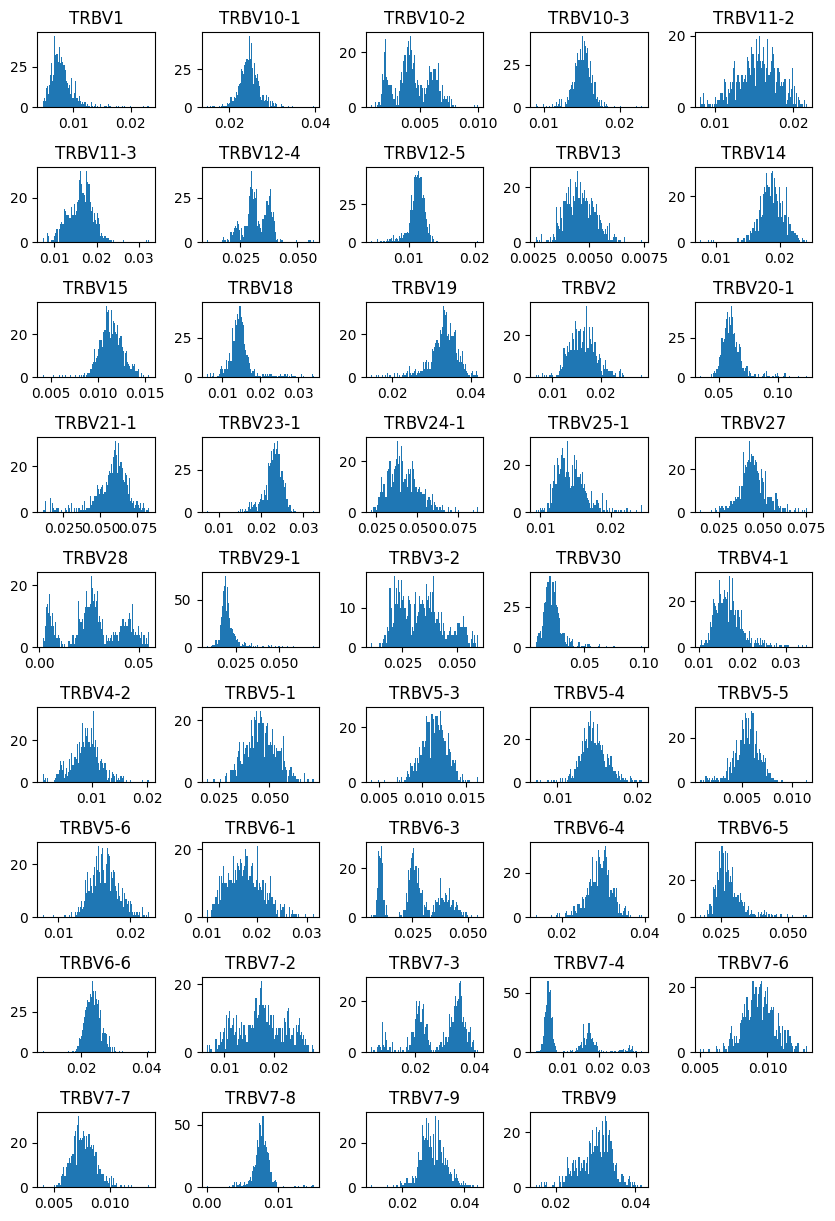

In [34]:
#nonfunc TRB-V
plot_hist_usage(v_gene_names_set_b, nf_trbv_matrix)

### Onlyfunctional

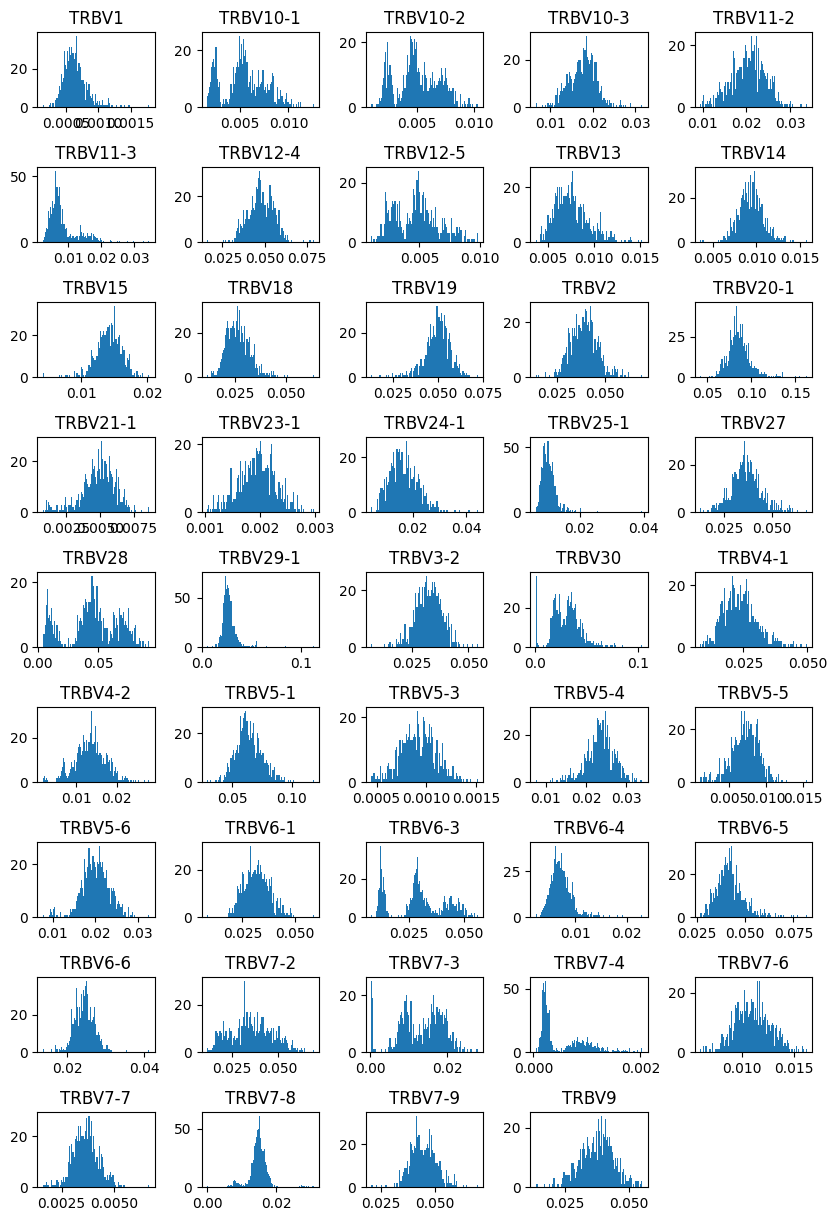

In [35]:
#onlyfunc TRB-V
plot_hist_usage(v_gene_names_set_b, of_trbv_matrix)

## Joint histograms (Nonfunctional vs Onlyfunctional)

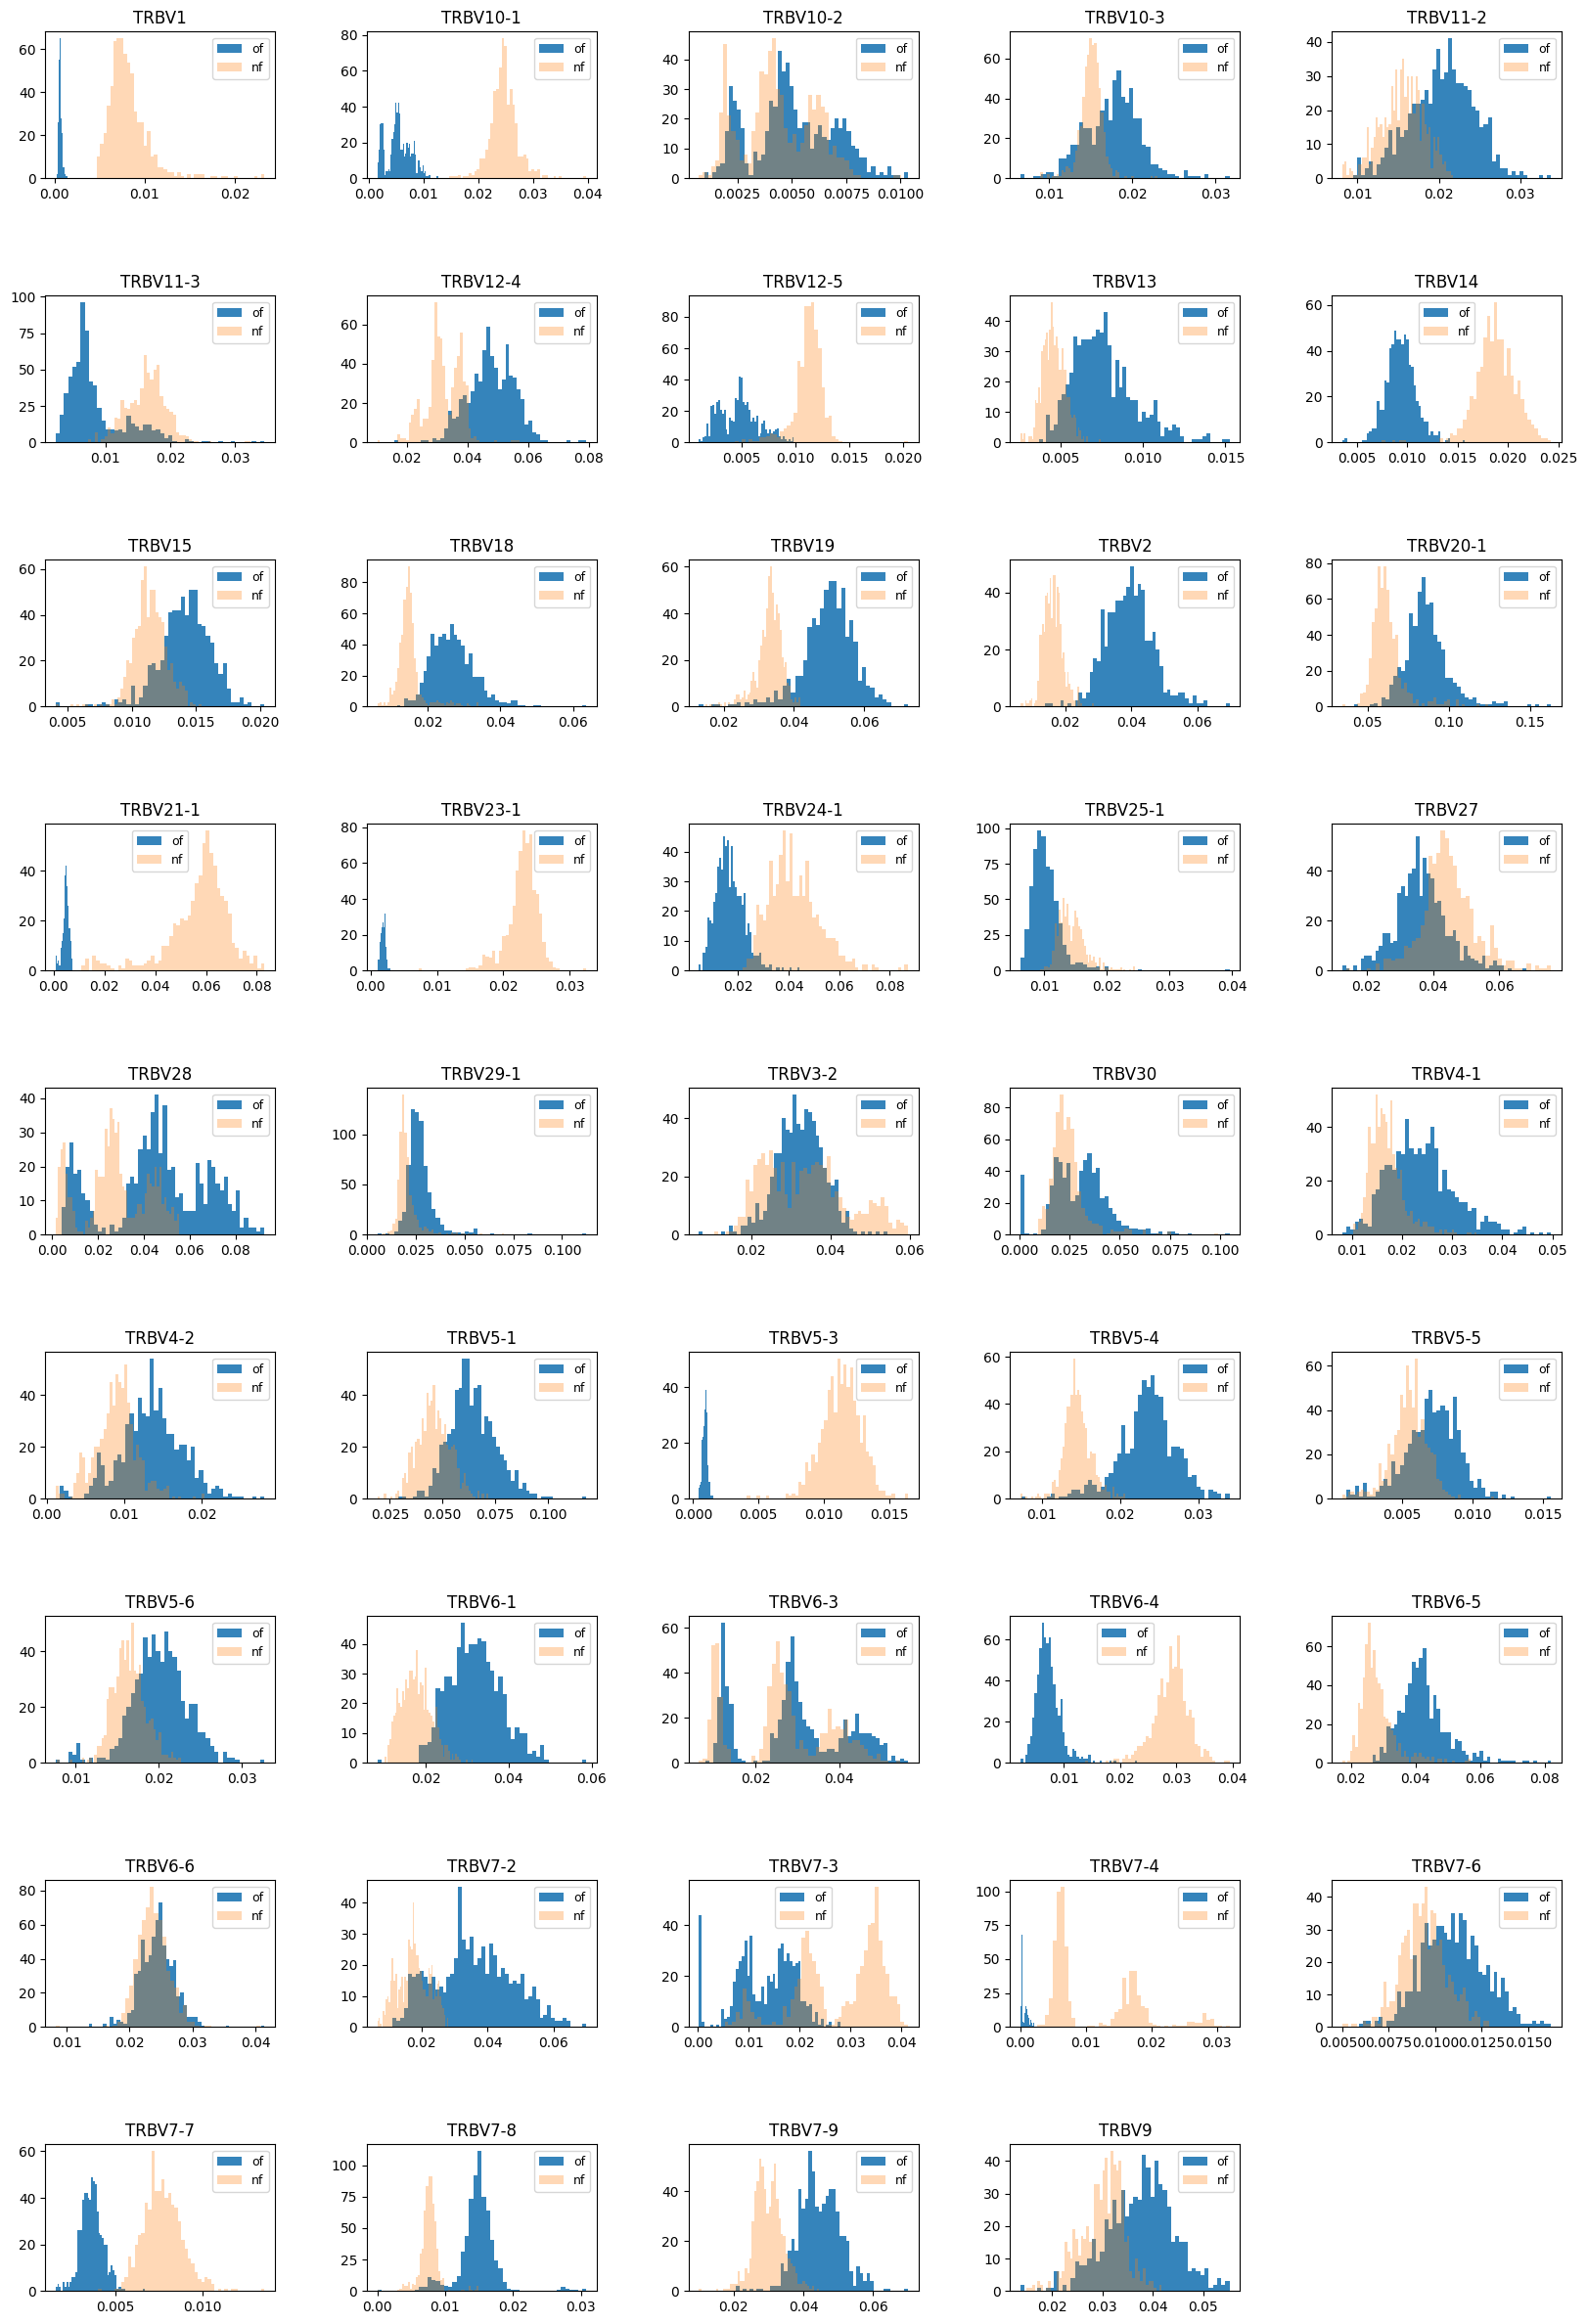

In [36]:
#onlyfunc и nonfunc TRB-V
plot_hist_of_vs_nf(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix)

### Kolmogorov-Smirnov test for nf vs of

In [37]:
#TRB-V
trbv_ks_test_p_values = calculate_p_value_ks_test(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix, True)
trbv_sign = {key: val for key, val in trbv_ks_test_p_values.items() if val <= 0.05}
trbv_sign

{'TRBV1': 0.0,
 'TRBV10-1': 0.0,
 'TRBV10-2': 9.520814123324601e-12,
 'TRBV10-3': 6.03867157009733e-98,
 'TRBV11-2': 3.281211903513203e-100,
 'TRBV11-3': 1.2946189875646063e-179,
 'TRBV12-4': 8.115303433430273e-218,
 'TRBV12-5': 1.36045109405571e-309,
 'TRBV13': 8.60262774302742e-220,
 'TRBV14': 0.0,
 'TRBV15': 1.0887892315900754e-141,
 'TRBV18': 4.057112671189272e-257,
 'TRBV19': 2.9060770822589544e-281,
 'TRBV2': 0.0,
 'TRBV20-1': 5.517880304248441e-212,
 'TRBV21-1': 0.0,
 'TRBV23-1': 0.0,
 'TRBV24-1': 5.936270216e-314,
 'TRBV25-1': 5.262378884182798e-183,
 'TRBV27': 1.1606212459546874e-62,
 'TRBV28': 2.0513955154348e-64,
 'TRBV29-1': 1.2859498672551648e-126,
 'TRBV3-2': 5.6735427256004054e-08,
 'TRBV30': 1.3426417864098733e-42,
 'TRBV4-1': 2.878620973910619e-96,
 'TRBV4-2': 8.808622559766988e-101,
 'TRBV5-1': 6.9857114079716475e-152,
 'TRBV5-3': 0.0,
 'TRBV5-4': 1.5502162779566078e-282,
 'TRBV5-5': 1.5136587933621362e-67,
 'TRBV5-6': 2.1993477507933433e-97,
 'TRBV6-1': 5.59732982837

## Scatterplots (Nonfunctional vs Onlyfunctional)

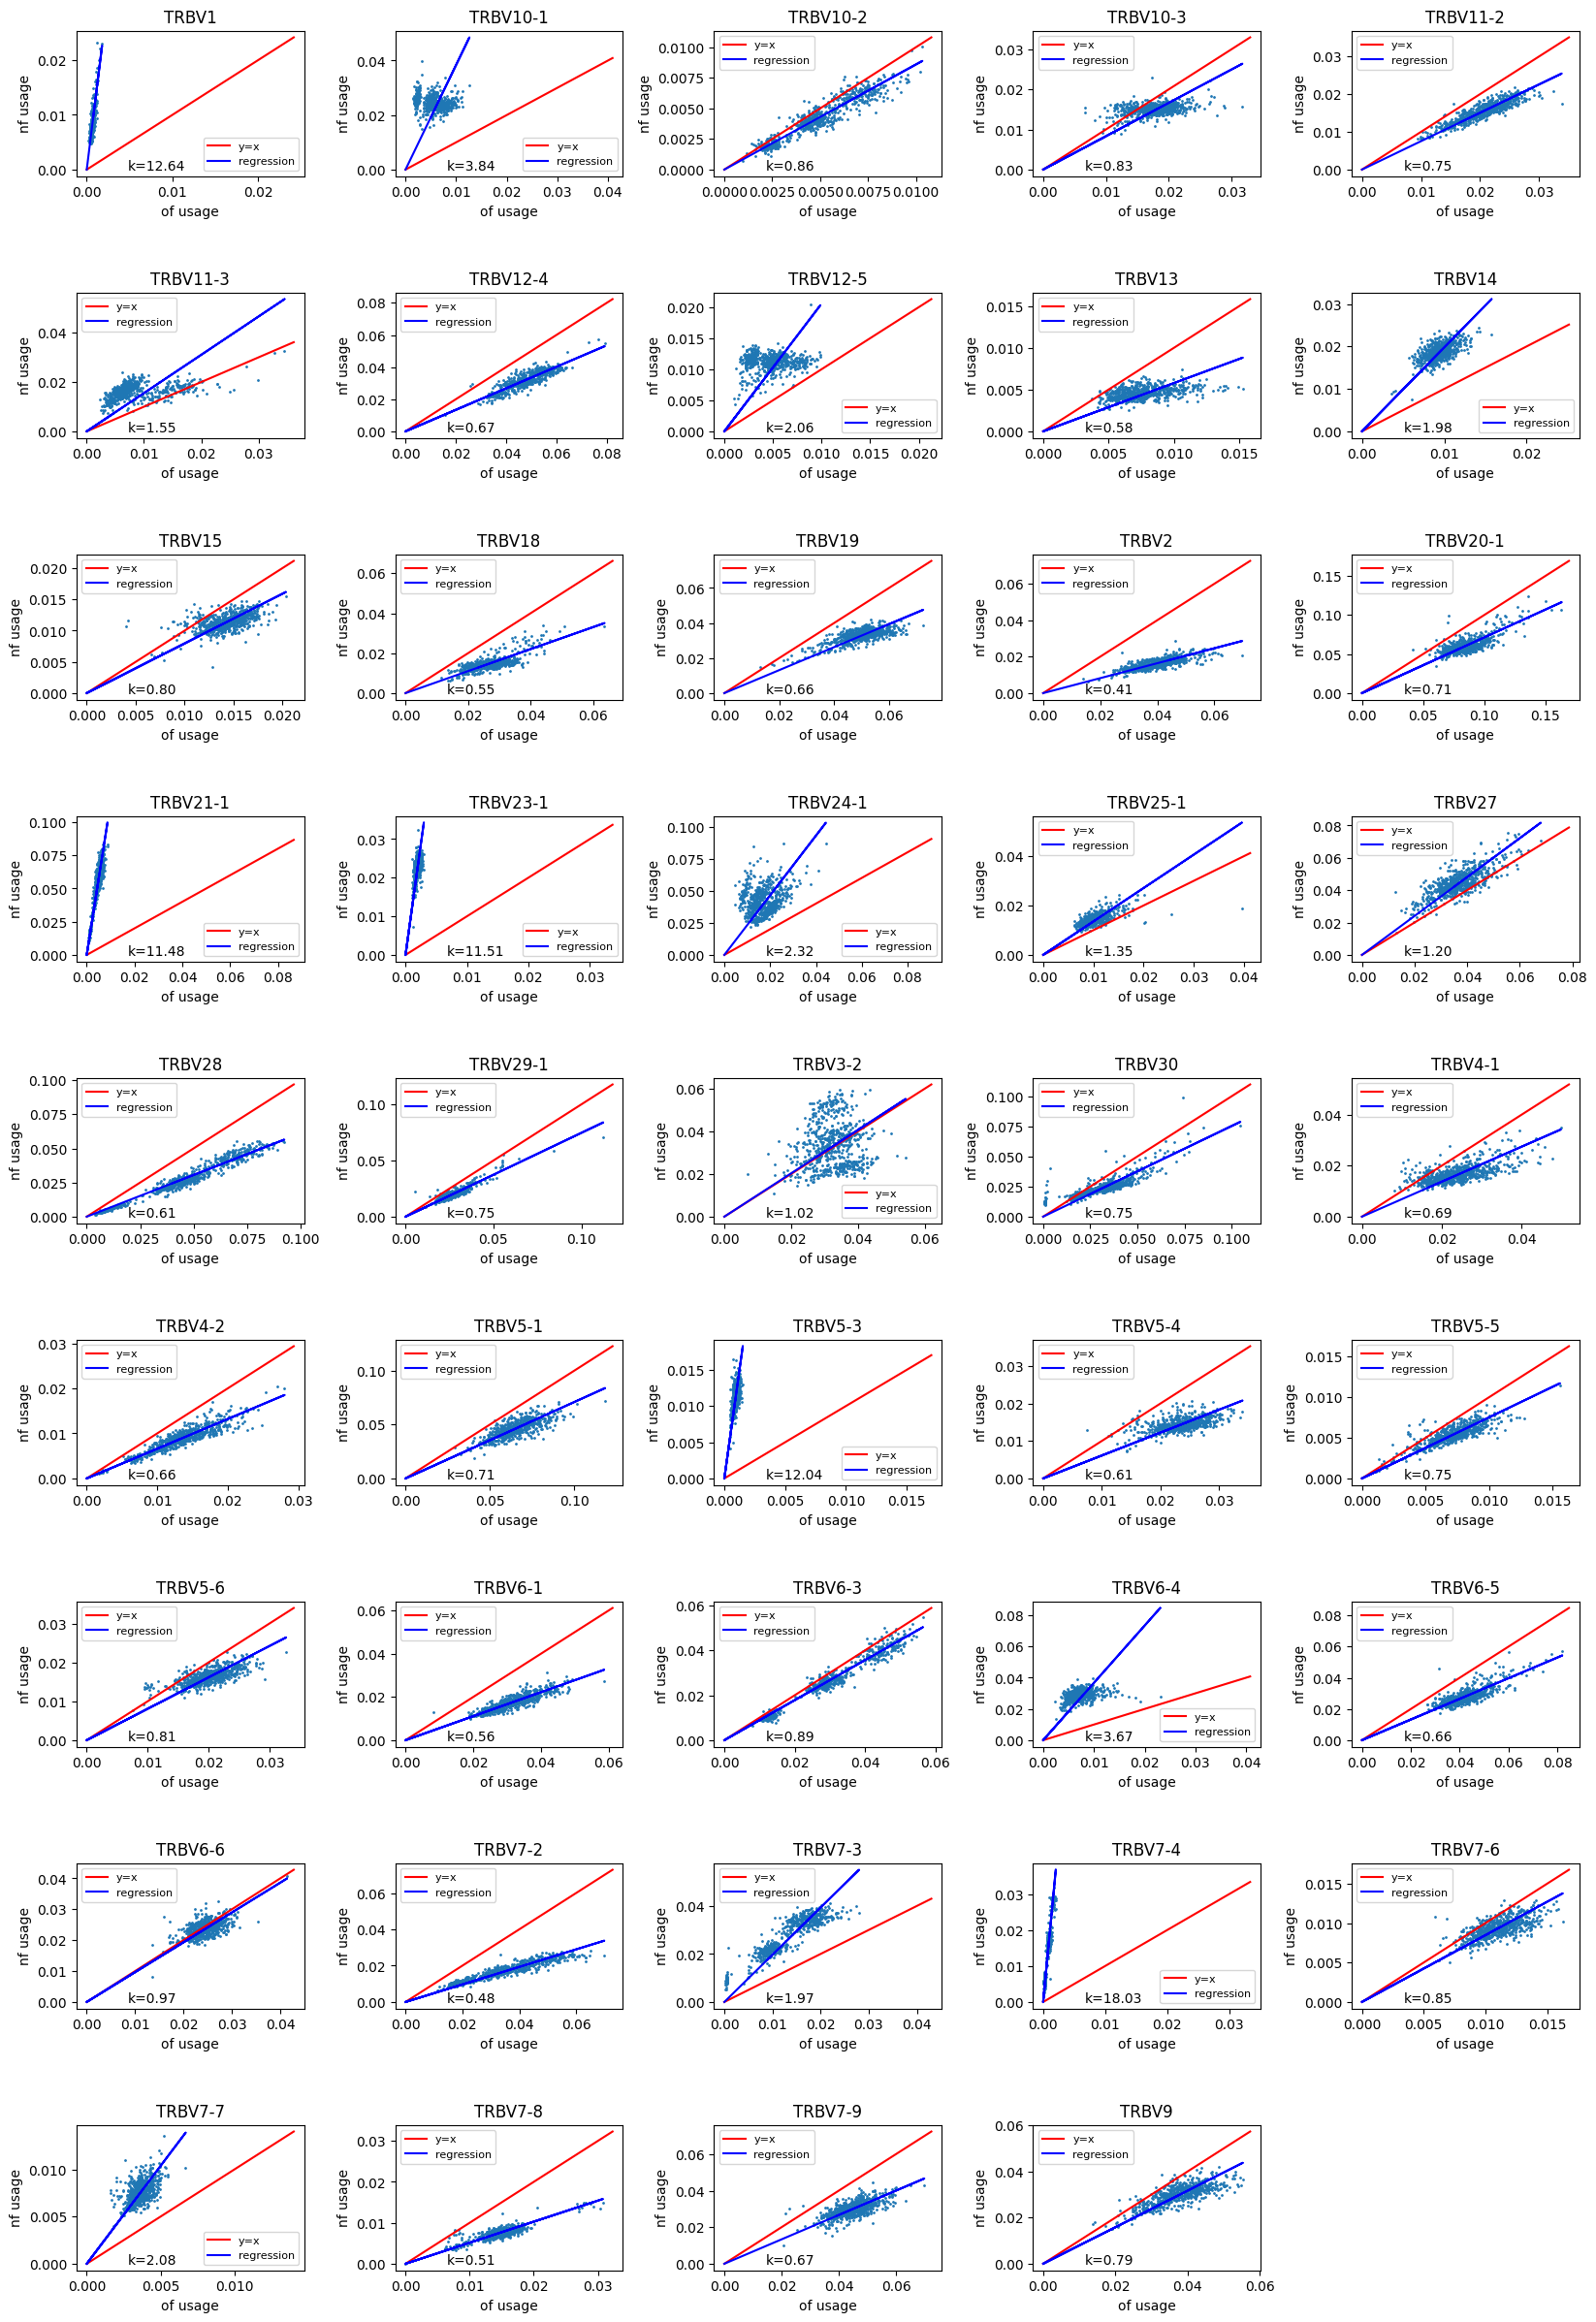

In [41]:
trbv_fit_koef = plot_scatter_of_vs_nf(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix)

In [42]:
trbv_fit_koef

,gene,koef
0,TRBV1,12.641298
1,TRBV10-1,3.841228
2,TRBV10-2,0.859048
3,TRBV10-3,0.831924
4,TRBV11-2,0.752764
5,TRBV11-3,1.552084
6,TRBV12-4,0.669642
7,TRBV12-5,2.055995
8,TRBV13,0.578170
9,TRBV14,1.978018


In [43]:
trbv_pseudo = ['TRBV12-1', 'TRBV12-2', 'TRBV21-1', 'TRBV3-2', 'TRBV7-5']

print('--Mean calculation--')
print(f'For full set of genes (total {len(trbv_fit_koef)} genes)  \t{round(np.mean(trbv_fit_koef.koef), 2)} \u00B1 {round(np.std(trbv_fit_koef.koef), 2)}')
print(f'Without preudogenes (total {len(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)])} genes) \t\t {round(np.mean(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)} \u00B1 {round(np.std(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)}')
print(f'Only pseudogenes (total {len(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)])} genes) \t\t {round(np.mean(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)} \u00B1 {round(np.std(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)}')

--Mean calculation--
For full set of genes (total 44 genes)  	2.46 ± 3.98
Without preudogenes (total 42 genes) 		 2.28 ± 3.82
Only pseudogenes (total 2 genes) 		 6.25 ± 5.23
